In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyturbseq as ptrb
import os

# Single cell QC 
### read in cellranger output

In [4]:
ROOT = '/data1/wgs_APA/validation_res/cellranger_out/'
GEM1 = ROOT + 'gem1/apa_gem1_16012024/'
GEM2 = ROOT + 'gem2/apa_gem2_16012024/'

In [5]:
## this is the path to the cellranger output. If you have multiple lanes, you would run this for each lane
gex_path = f'{GEM1}/filtered_feature_bc_matrix.h5'


adata = sc.read_10x_h5(gex_path, gex_only=False)

adata.var_names_make_unique()
adata.obs_names_make_unique()

adata

/home/aiden/anaconda3/envs/pyturb/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 34699 × 36749
    var: 'gene_ids', 'feature_types', 'genome'

## Add sgRNA calls from cellranger
cellranger provides sgRNA calls and analysis when running cellranger count with a feature library.

In [6]:
from pyturbseq.utils import add_CR_sgRNA, split_by_feature_type

crispr_out = f'{GEM1}/'
print(f"Getting CRISPR Analysis from: {crispr_out}")

#get CR sgRNA assignment for list of cell barcodes
adata = add_CR_sgRNA(
    adata,
    crispr_out 
    )
adata.obs.head()

Getting CRISPR Analysis from: /data1/wgs_APA/validation_res/cellranger_out/gem1/apa_gem1_16012024//
Found sgRNA information for 18733/34699 (53.99%) of cell barcodes


,num_features,feature_call,num_umis
AAACCCAAGACGCTCC-1,2.0,EPB41L5-1|EPB41L5-2,839|501
AAACCCAAGCATCCCG-1,NaN,NaN,NaN
AAACCCAAGCTAATCC-1,NaN,NaN,NaN
AAACCCAAGCTGACCC-1,1.0,PROX1-1,20
AAACCCAAGGACTGGT-1,2.0,CREB5-1|CREB5-2,78|9


# Assigning confident calls to 'perturbation' column
Here we do some further filtering and formating for confident guide calls. While cellranger guide calls tend to be fairly good, this data is still unfiltered.

Additionally, it is favorable to format the guide call. This can be to directly map the guide call to a gene, to merge multi gene perturbations with different order, and to format guides for downstream analysis like DESeq2.

## Check the distribution of # of guide calls per cell
For single guide cases, we expect to see a majority of cells with 1 guide. For dual guide cases, we expect to see a majority of cells with 2 guides.

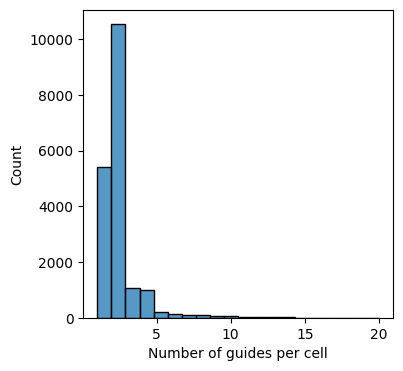

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.histplot(adata.obs['num_features'], ax=ax, bins=20)
ax.set_xlabel('Number of guides per cell')
plt.show()

In [14]:
acceptable_ntcs_1 = ['negative_control_1-1','negative_control_1-2','negative_control_2-1',
                   'negative_control_2-2','negative_control_3-1','negative_control_3-2',
                   'negative_control_4-1','negative_control_4-2','negative_control_5-1',
                   'negative_control_5-2','negative_control_6-1','negative_control_6-2']

acceptable_ntcs_2 = ['negative_control_1-3','negative_control_1-4','negative_control_2-3',
                   'negative_control_2-4','negative_control_3-3','negative_control_3-4',
                   'negative_control_4-3','negative_control_4-4','negative_control_5-3',
                   'negative_control_5-4','negative_control_6-3','negative_control_6-4']

In [15]:
def contains_valid_ntc_pair(feature_call):
    parts = str(feature_call).split('|')
    return len(parts) == 2 and all(part in acceptable_ntcs_1 for part in parts)

# Filter the DataFrame
tst = adata.obs[adata.obs['feature_call'].apply(contains_valid_ntc_pair)]
tst

,num_features,feature_call,num_umis
AAACGAACATCCAATG-1,2.0,negative_control_4-1|negative_control_4-2,421|213
AAACGCTCACGTCGGT-1,2.0,negative_control_3-1|negative_control_3-2,228|53
AAACGCTTCTCTAAGG-1,2.0,negative_control_3-1|negative_control_3-2,815|222
AAAGAACAGAAATGGG-1,2.0,negative_control_5-1|negative_control_5-2,1401|163
AAAGGTAAGAGCCCAA-1,2.0,negative_control_3-1|negative_control_3-2,586|74
...,...,...,...
TTTGGAGAGCGACTTT-1,2.0,negative_control_5-1|negative_control_5-2,1218|240
TTTGGAGAGTCACAGG-1,2.0,negative_control_6-1|negative_control_6-2,77|38
TTTGGTTAGTTCGCAT-1,2.0,negative_control_5-1|negative_control_5-2,289|65
TTTGGTTCATGGCCCA-1,2.0,negative_control_3-1|negative_control_3-2,344|69


In [16]:
def is_negative_control(feature_call):
    parts = str(feature_call).split('|')
    return 1 if (len(parts) == 2 and all(part in acceptable_ntcs_1 for part in parts)) else 0

adata.obs['feature_call'] = adata.obs['feature_call'].astype(str)
adata.obs['is_negative_control'] = adata.obs['feature_call'].apply(is_negative_control)
adata.obs[adata.obs['is_negative_control'] == 1]

,num_features,feature_call,num_umis,is_negative_control
AAACGAACATCCAATG-1,2.0,negative_control_4-1|negative_control_4-2,421|213,1
AAACGCTCACGTCGGT-1,2.0,negative_control_3-1|negative_control_3-2,228|53,1
AAACGCTTCTCTAAGG-1,2.0,negative_control_3-1|negative_control_3-2,815|222,1
AAAGAACAGAAATGGG-1,2.0,negative_control_5-1|negative_control_5-2,1401|163,1
AAAGGTAAGAGCCCAA-1,2.0,negative_control_3-1|negative_control_3-2,586|74,1
...,...,...,...,...
TTTGGAGAGCGACTTT-1,2.0,negative_control_5-1|negative_control_5-2,1218|240,1
TTTGGAGAGTCACAGG-1,2.0,negative_control_6-1|negative_control_6-2,77|38,1
TTTGGTTAGTTCGCAT-1,2.0,negative_control_5-1|negative_control_5-2,289|65,1
TTTGGTTCATGGCCCA-1,2.0,negative_control_3-1|negative_control_3-2,344|69,1


In [17]:
from pyturbseq.utils import split_compare
#this function splits a feature call from cellranger, removes guide specific information (separated by underscore), and then returns consensus dual guide calls
adata.obs['perturbation'] = [split_compare(x,delim2='-',expected_num=2) for x in adata.obs['feature_call']] 
perturbed_cells = adata.obs['is_negative_control'] == 0
adata.obs['target_gene'] = None
adata.obs.loc[perturbed_cells, 'target_gene']  = adata.obs.loc[perturbed_cells, 'perturbation'] 
adata.obs.head()


,num_features,feature_call,num_umis,is_negative_control,perturbation,target_gene
AAACCCAAGACGCTCC-1,2.0,EPB41L5-1|EPB41L5-2,839|501,0,EPB41L5,EPB41L5
AAACCCAAGCATCCCG-1,NaN,nan,NaN,0,None,None
AAACCCAAGCTAATCC-1,NaN,nan,NaN,0,None,None
AAACCCAAGCTGACCC-1,1.0,PROX1-1,20,0,None,None
AAACCCAAGGACTGGT-1,2.0,CREB5-1|CREB5-2,78|9,0,CREB5,CREB5


# Filter to confident guide calls

In [18]:
print(f"{np.sum(adata.obs['perturbation'].notna())}/{adata.shape[0]} cells have a guide assignment")
adata = adata[adata.obs['perturbation'].notna(), :] #remove cells that do not have a guide assignment
adata


7832/34699 cells have a guide assignment


View of AnnData object with n_obs × n_vars = 7832 × 36749
    obs: 'num_features', 'feature_call', 'num_umis', 'is_negative_control', 'perturbation', 'target_gene'
    var: 'gene_ids', 'feature_types', 'genome'

In [19]:
adata.obs

,num_features,feature_call,num_umis,is_negative_control,perturbation,target_gene
AAACCCAAGACGCTCC-1,2.0,EPB41L5-1|EPB41L5-2,839|501,0,EPB41L5,EPB41L5
AAACCCAAGGACTGGT-1,2.0,CREB5-1|CREB5-2,78|9,0,CREB5,CREB5
AAACCCAAGTGCGTCC-1,2.0,NR5A1-1|NR5A1-2,988|155,0,NR5A1,NR5A1
AAACCCACAAGTCGTT-1,2.0,ETS1-1|ETS1-2,521|162,0,ETS1,ETS1
AAACCCAGTCGATTCA-1,2.0,MED1-1|MED1-2,437|53,0,MED1,MED1
...,...,...,...,...,...,...
TTTGTTGAGCGAACTG-1,2.0,MECOM-1|MECOM-2,221|74,0,MECOM,MECOM
TTTGTTGAGCGTGAGT-1,2.0,negative_control_6-1|negative_control_6-2,545|235,1,negative_control_6,None
TTTGTTGCACATCATG-1,2.0,ZNF527-1|ZNF527-2,224|46,0,ZNF527,ZNF527
TTTGTTGGTGCTCTTC-1,2.0,SENP3-1|SENP3-2,30|106,0,SENP3,SENP3


In [20]:
adata.var['feature_types'].value_counts()

feature_types
Gene Expression         36601
CRISPR Guide Capture      148
Name: count, dtype: int64

In [21]:
out = split_by_feature_type(adata)
adata = out['Gene Expression']
adata_sgRNA = out['CRISPR Guide Capture']

In [22]:
adata

AnnData object with n_obs × n_vars = 7832 × 36601
    obs: 'num_features', 'feature_call', 'num_umis', 'is_negative_control', 'perturbation', 'target_gene'
    var: 'gene_ids', 'feature_types', 'genome'

In [23]:
#add mito gene content and scanpy metrics (most importantly n_genes_by_counts and total_counts)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata

AnnData object with n_obs × n_vars = 7832 × 36601
    obs: 'num_features', 'feature_call', 'num_umis', 'is_negative_control', 'perturbation', 'target_gene', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [28]:
adata.obs['perturbation'] = adata.obs['perturbation'].str.replace(r'negative_control_\d', 'negative_control', regex=True)
adata.obs

,num_features,feature_call,num_umis,is_negative_control,perturbation,target_gene,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,target_pct_change,target_zscore,target_reference_mean,target_reference_std,target_gene_expression
AAACCCAAGACGCTCC-1,2.0,EPB41L5-1|EPB41L5-2,839|501,0,EPB41L5,EPB41L5,5110,23441.0,2827.0,12.060065,NaN,NaN,NaN,NaN,NaN
AAACCCAAGGACTGGT-1,2.0,CREB5-1|CREB5-2,78|9,0,CREB5,CREB5,3800,13247.0,1649.0,12.448101,NaN,NaN,NaN,NaN,NaN
AAACCCAAGTGCGTCC-1,2.0,NR5A1-1|NR5A1-2,988|155,0,NR5A1,NR5A1,3767,14068.0,2121.0,15.076770,NaN,NaN,NaN,NaN,NaN
AAACCCACAAGTCGTT-1,2.0,ETS1-1|ETS1-2,521|162,0,ETS1,ETS1,4371,15120.0,1550.0,10.251323,NaN,NaN,NaN,NaN,NaN
AAACCCAGTCGATTCA-1,2.0,MED1-1|MED1-2,437|53,0,MED1,MED1,3385,8370.0,706.0,8.434887,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGAGCGAACTG-1,2.0,MECOM-1|MECOM-2,221|74,0,MECOM,MECOM,4509,18184.0,3076.0,16.915970,NaN,NaN,NaN,NaN,NaN
TTTGTTGAGCGTGAGT-1,2.0,negative_control_6-1|negative_control_6-2,545|235,1,negative_control,NaN,4702,21059.0,3382.0,16.059641,NaN,NaN,NaN,NaN,NaN
TTTGTTGCACATCATG-1,2.0,ZNF527-1|ZNF527-2,224|46,0,ZNF527,ZNF527,4881,19974.0,2633.0,13.182137,NaN,NaN,NaN,NaN,NaN
TTTGTTGGTGCTCTTC-1,2.0,SENP3-1|SENP3-2,30|106,0,SENP3,SENP3,4958,20167.0,2431.0,12.054346,NaN,NaN,NaN,NaN,NaN


In [25]:
from pyturbseq.utils import filter_adata

#this function provides a way to list multiple filters for cells (obs) and genes (var)
adata = filter_adata(
    adata,
    obs_filters=[
        "n_genes_by_counts > 2000",
        "pct_counts_mt < 20",
        "total_counts > 6000",
    ],
    var_filters=[
        'n_cells_by_counts > 50',
        'total_counts > 100'
    ]
    )
adata

View of AnnData object with n_obs × n_vars = 7595 × 15709
    obs: 'num_features', 'feature_call', 'num_umis', 'is_negative_control', 'perturbation', 'target_gene', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [29]:
from pyturbseq.utils import calculate_target_change


adata = calculate_target_change(
    adata,
    'perturbation',
    'negative_control',
    check_norm=True #default option
    )


Computing percent change for 'perturbation' across 7595 cells...
	Checking if data is normalized to counts per cell...
	Computing percent change for each cell...
	Found 68 unique perturbations in perturbation column.
	Removed 12 perturbations not found in adata.var_names.
	Computing mean expression values for reference population: negative_control....
	Computing percent change for 5823 perturbed cells...


5823it [00:00, 162805.52it/s]


In [74]:
adata

AnnData object with n_obs × n_vars = 7216 × 15601
    obs: 'num_features', 'feature_call', 'num_umis', 'is_negative_control', 'perturbation', 'target_gene', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'target_pct_change', 'target_zscore', 'target_reference_mean', 'target_reference_std', 'target_gene_expression'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [79]:
adata.obs['target_pct_change']

AAACCCAAGACGCTCC-1   -100.0
AAACCCAAGGACTGGT-1      NaN
AAACCCAAGTGCGTCC-1      NaN
AAACCCACAAGTCGTT-1      NaN
AAACCCAGTCGATTCA-1   -100.0
                      ...  
TTTGTTGAGCGAACTG-1   -100.0
TTTGTTGAGCGTGAGT-1      NaN
TTTGTTGCACATCATG-1   -100.0
TTTGTTGGTGCTCTTC-1   -100.0
TTTGTTGTCCCTCATG-1   -100.0
Name: target_pct_change, Length: 7216, dtype: float64

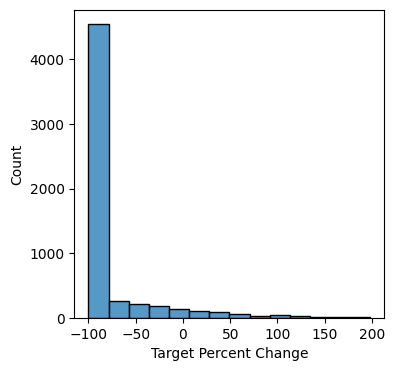

In [31]:
tmp = adata.obs['target_pct_change'].copy()
tmp = tmp[tmp.notna()]
tmp = tmp[tmp < 200]
fig, ax = plt.subplots(figsize=(4, 4))
sns.histplot(tmp, ax=ax)
ax.set_xlabel('Target Percent Change')
plt.show()


In [32]:
## filter out cells that dont have at least 10% KD
adata = adata[adata.obs['target_pct_change'] < -20, :]
adata

View of AnnData object with n_obs × n_vars = 5151 × 15709
    obs: 'num_features', 'feature_call', 'num_umis', 'is_negative_control', 'perturbation', 'target_gene', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'target_pct_change', 'target_zscore', 'target_reference_mean', 'target_reference_std', 'target_gene_expression'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [35]:
# lets make a text file with cell barcodes for each perturbation
barcodes_dir = '/data1/wgs_APA/validation_res/cellranger_out/gem1/CB_barcodes/'
if not os.path.exists(barcodes_dir):
    os.makedirs(barcodes_dir)

perturbations = adata.obs['perturbation'].unique()

for pert in perturbations:
    tmp = adata[adata.obs['perturbation'] == pert, :]
    tmp.obs_names.to_series().to_csv(f'{barcodes_dir}/{pert}.txt', header=False, index=False)


# GEM 2

In [36]:
# this is the path to the cellranger output. If you have multiple lanes, you would run this for each lane
gex_path = f'{GEM2}/filtered_feature_bc_matrix.h5'


adata = sc.read_10x_h5(gex_path, gex_only=False)

adata.var_names_make_unique()
adata.obs_names_make_unique()

adata

/home/aiden/anaconda3/envs/pyturb/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 35441 × 36749
    var: 'gene_ids', 'feature_types', 'genome'

In [38]:
crispr_out = f'{GEM2}/'
print(f"Getting CRISPR Analysis from: {crispr_out}")

#get CR sgRNA assignment for list of cell barcodes
adata = add_CR_sgRNA(
    adata,
    crispr_out 
    )
adata.obs.head()

Getting CRISPR Analysis from: /data1/wgs_APA/validation_res/cellranger_out/gem2/apa_gem2_16012024//
Found sgRNA information for 17487/35441 (49.34%) of cell barcodes


,num_features,feature_call,num_umis
AAACCCAAGATGACAT-1,4.0,PPP1R12A-3|PPP1R12A-4|PROX1-3|PROX1-4,46|77|1464|389
AAACCCAAGATTAGTG-1,NaN,NaN,NaN
AAACCCAAGCGCCTAC-1,2.0,ZNF345-3|ZNF345-4,490|717
AAACCCAAGCGTGTTT-1,2.0,UBE2D2-3|UBE2D2-4,304|283
AAACCCAAGCTCGGCT-1,1.0,KLF9-4,16


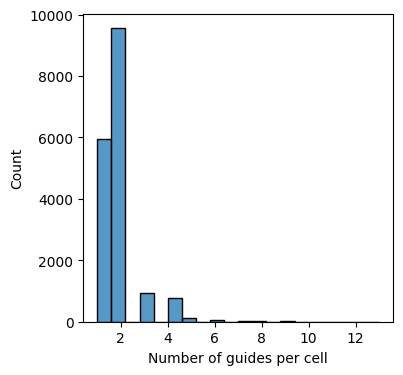

In [40]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.histplot(adata.obs['num_features'], ax=ax, bins=20)
ax.set_xlabel('Number of guides per cell')
plt.show()

In [39]:
def is_negative_control(feature_call):
    parts = str(feature_call).split('|')
    return 1 if (len(parts) == 2 and all(part in acceptable_ntcs_2 for part in parts)) else 0

adata.obs['feature_call'] = adata.obs['feature_call'].astype(str)
adata.obs['is_negative_control'] = adata.obs['feature_call'].apply(is_negative_control)
adata.obs[adata.obs['is_negative_control'] == 1]

,num_features,feature_call,num_umis,is_negative_control
AAACCCAAGTAGCATA-1,2.0,negative_control_3-3|negative_control_3-4,214|22,1
AAAGAACGTTGACGGA-1,2.0,negative_control_2-3|negative_control_2-4,649|7,1
AAAGTCCAGTACAGCG-1,2.0,negative_control_6-3|negative_control_6-4,242|29,1
AAAGTCCGTTGGACCC-1,2.0,negative_control_3-3|negative_control_3-4,1537|623,1
AAAGTGACAATGTGGG-1,2.0,negative_control_1-3|negative_control_1-4,16|23,1
...,...,...,...,...
TTTATGCAGCAAATGT-1,2.0,negative_control_1-3|negative_control_1-4,46|46,1
TTTGATCCAATTGCCA-1,2.0,negative_control_2-3|negative_control_2-4,159|3,1
TTTGATCTCCACTGGG-1,2.0,negative_control_4-3|negative_control_4-4,208|80,1
TTTGTTGCATATAGCC-1,2.0,negative_control_4-3|negative_control_4-4,220|58,1


In [41]:
adata.obs['perturbation'] = [split_compare(x,delim2='-',expected_num=2) for x in adata.obs['feature_call']] 
perturbed_cells = adata.obs['is_negative_control'] == 0
adata.obs['target_gene'] = None
adata.obs.loc[perturbed_cells, 'target_gene']  = adata.obs.loc[perturbed_cells, 'perturbation'] 
adata.obs.head()


,num_features,feature_call,num_umis,is_negative_control,perturbation,target_gene
AAACCCAAGATGACAT-1,4.0,PPP1R12A-3|PPP1R12A-4|PROX1-3|PROX1-4,46|77|1464|389,0,None,None
AAACCCAAGATTAGTG-1,NaN,nan,NaN,0,None,None
AAACCCAAGCGCCTAC-1,2.0,ZNF345-3|ZNF345-4,490|717,0,ZNF345,ZNF345
AAACCCAAGCGTGTTT-1,2.0,UBE2D2-3|UBE2D2-4,304|283,0,UBE2D2,UBE2D2
AAACCCAAGCTCGGCT-1,1.0,KLF9-4,16,0,None,None


In [42]:
print(f"{np.sum(adata.obs['perturbation'].notna())}/{adata.shape[0]} cells have a guide assignment")
adata = adata[adata.obs['perturbation'].notna(), :] #remove cells that do not have a guide assignment

out = split_by_feature_type(adata)
adata = out['Gene Expression']
adata_sgRNA = out['CRISPR Guide Capture']


adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


adata.obs['perturbation'] = adata.obs['perturbation'].str.replace(r'negative_control_\d', 'negative_control', regex=True)

#this function provides a way to list multiple filters for cells (obs) and genes (var)
adata = filter_adata(
    adata,
    obs_filters=[
        "n_genes_by_counts > 2000",
        "pct_counts_mt < 20",
        "total_counts > 6000",
    ],
    var_filters=[
        'n_cells_by_counts > 50',
        'total_counts > 100'
    ]
    )
adata



7122/35441 cells have a guide assignment


View of AnnData object with n_obs × n_vars = 7100 × 15317
    obs: 'num_features', 'feature_call', 'num_umis', 'is_negative_control', 'perturbation', 'target_gene', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Computing percent change for 'perturbation' across 7100 cells...
	Checking if data is normalized to counts per cell...
	Computing percent change for each cell...
	Found 68 unique perturbations in perturbation column.
	Removed 13 perturbations not found in adata.var_names.
	Computing mean expression values for reference population: negative_control....
	Computing percent change for 5297 perturbed cells...


5297it [00:00, 160624.27it/s]
/home/aiden/anaconda3/envs/pyturb/lib/python3.11/site-packages/pyturbseq/utils.py:302: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  final_adata.obs[m] = np.nan


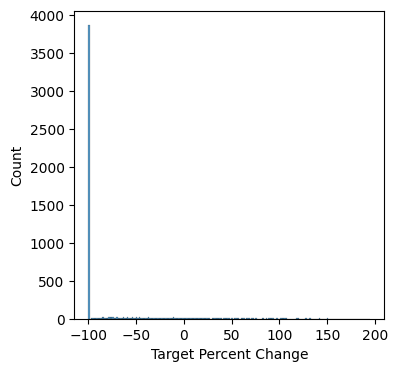

In [43]:
adata = calculate_target_change(
    adata,
    'perturbation',
    'negative_control',
    check_norm=True #default option
    )

tmp = adata.obs['target_pct_change'].copy()
tmp = tmp[tmp.notna()]
tmp = tmp[tmp < 200]
fig, ax = plt.subplots(figsize=(4, 4))
sns.histplot(tmp, ax=ax)
ax.set_xlabel('Target Percent Change')
plt.show()


In [44]:
adata = adata[adata.obs['target_pct_change'] < -20, :]


# lets make a text file with cell barcodes for each perturbation
barcodes_dir = '/data1/wgs_APA/validation_res/cellranger_out/gem2/CB_barcodes/'
if not os.path.exists(barcodes_dir):
    os.makedirs(barcodes_dir)

perturbations = adata.obs['perturbation'].unique()

for pert in perturbations:
    tmp = adata[adata.obs['perturbation'] == pert, :]
    tmp.obs_names.to_series().to_csv(f'{barcodes_dir}/{pert}.txt', header=False, index=False)


In [45]:
adata.obs

,num_features,feature_call,num_umis,is_negative_control,perturbation,target_gene,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,target_pct_change,target_zscore,target_reference_mean,target_reference_std,target_gene_expression
AAACCCAAGCGCCTAC-1,2.0,ZNF345-3|ZNF345-4,490|717,0,ZNF345,ZNF345,7555,49869.0,3765.0,7.549781,-100.0,-0.288067,0.085768,0.297737,0.0
AAACCCAAGCGTGTTT-1,2.0,UBE2D2-3|UBE2D2-4,304|283,0,UBE2D2,UBE2D2,5413,26377.0,3302.0,12.518482,-100.0,-1.731980,3.529742,2.037981,0.0
AAACCCATCCACCCTA-1,2.0,GLYR1-3|GLYR1-4,2531|952,0,GLYR1,GLYR1,7124,46006.0,1630.0,3.543016,-100.0,-1.427311,2.501203,1.752389,0.0
AAACGAAAGCGAGTAC-1,2.0,NFIB-3|NFIB-4,234|274,0,NFIB,NFIB,5683,27955.0,2308.0,8.256126,-100.0,-0.906319,1.120959,1.236827,0.0
AAACGAACAAACACCT-1,2.0,BIRC2-3|BIRC2-4,470|144,0,BIRC2,BIRC2,4421,16306.0,963.0,5.905801,-100.0,-0.695327,0.600737,0.863963,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCAGGACAGT-1,2.0,GLYR1-3|GLYR1-4,52|10,0,GLYR1,GLYR1,4104,13845.0,1359.0,9.815818,-100.0,-1.427311,2.501203,1.752389,0.0
TTTGTTGCATGCAGCC-1,2.0,IFITM2-3|IFITM2-4,89|64,0,IFITM2,IFITM2,4167,16233.0,1181.0,7.275303,-100.0,-1.178319,2.256144,1.914713,0.0
TTTGTTGGTCTGTGTA-1,2.0,BRIP1-3|BRIP1-4,158|23,0,BRIP1,BRIP1,3684,11918.0,793.0,6.653800,-100.0,-1.029028,2.770278,2.692130,0.0
TTTGTTGGTTGCACGC-1,2.0,RDH11-3|RDH11-4,177|71,0,RDH11,RDH11,6376,30098.0,2161.0,7.179879,-100.0,-0.855489,0.889288,1.039508,0.0


# Make bash file to subset bams


In [4]:
# Paths
bam_path = '/data1/wgs_APA/validation_res/cellranger_out/gem1/apa_gem1_16012024/possorted_genome_bam.bam'
barcodes_dir = '/data1/wgs_APA/validation_res/cellranger_out/gem1/CB_barcodes/'
out_dir = '/data1/wgs_APA/validation_res/cellranger_out/gem1/gene_bams/'

# List all barcode files
barcode_files = os.listdir(barcodes_dir)

# Start of the bash script
bash_script = "#!/bin/bash\n"

# Generate command for each barcode file
for file in barcode_files:
    gene_name = os.path.splitext(file)[0]
    command = f"/home/aiden/softwares/subset_bam --bam {bam_path} --cell-barcodes {barcodes_dir}{file} --out-bam {out_dir}{gene_name}.bam &\n"
    bash_script += command

# Write to a bash script file
with open('/data1/wgs_APA/validation_res/cellranger_out/gem1/apa_gem1_16012024/subset_bams.sh', 'w') as f:
    f.write(bash_script)


In [5]:
# Paths
bam_path = '/data1/wgs_APA/validation_res/cellranger_out/gem2/apa_gem2_16012024/possorted_genome_bam.bam'
barcodes_dir = '/data1/wgs_APA/validation_res/cellranger_out/gem2/CB_barcodes/'
out_dir = '/data1/wgs_APA/validation_res/cellranger_out/gem2/gene_bams/'

# List all barcode files
barcode_files = os.listdir(barcodes_dir)

# Start of the bash script
bash_script = "#!/bin/bash\n"

# Generate command for each barcode file
for file in barcode_files:
    gene_name = os.path.splitext(file)[0]
    command = f"/home/aiden/softwares/subset_bam --bam {bam_path} --cell-barcodes {barcodes_dir}{file} --out-bam {out_dir}{gene_name}.bam &\n"
    bash_script += command

# Write to a bash script file
with open('/data1/wgs_APA/validation_res/cellranger_out/gem2/apa_gem2_16012024/subset_bams.sh', 'w') as f:
    f.write(bash_script)
